In [18]:
# Importer les depondances
import os
import re
import numpy as np
import pandas as pd

# la visualisation
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.tools as tls
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.express as px
init_notebook_mode(connected=True)

# traitement de langage naturel
import string 
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# preparation des donnée et la creation du modele d'apprentissage
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# evaluation des performances 
from sklearn.metrics import confusion_matrix, classification_report

# les classificateurs 
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB

import warnings
warnings.filterwarnings('ignore')

sns.set_style("darkgrid")

In [19]:
complaints_df = pd.read_csv('complaints.csv')

In [20]:
print(f'The dataset has {complaints_df.shape[0]} rows and {complaints_df.shape[1]} columns(features).')

The dataset has 2102124 rows and 18 columns(features).


In [21]:
# la creation d'un nouveu datafram contenant deux colonne essentielle à l'apprentissage
df1 = complaints_df[['Product', 'Consumer complaint narrative']].copy()

# la suppression des NAN
df1 = df1[pd.notnull(df1['Consumer complaint narrative'])]

# renomer la colonne 
df1.columns = ['Product', 'complaint'] 

df1.shape

(723250, 2)

In [35]:
df1.head()

,complaint,Product,Complaint_Tokenized
0,transworld systems inc. \nis trying to collect...,Debt collection,"[transworld, systems, inc., trying, collect, d..."
2,"Over the past 2 weeks, I have been receiving e...",Debt collection,"[past, weeks, receiving, excessive, amounts, t..."
7,"Previously, on XX/XX/XXXX, XX/XX/XXXX, and XX/...","Credit reporting, credit repair services, or o...","[previously, requested, experian, send, copy, ..."
8,Hello This complaint is against the three cred...,"Credit reporting, credit repair services, or o...","[hello, complaint, three, credit, reporting, c..."
12,Today XX/XX/XXXX went online to dispute the in...,"Credit reporting, credit repair services, or o...","[today, went, online, dispute, incorrect, pers..."


In [23]:
df1['complaint'][0]

'transworld systems inc. \nis trying to collect a debt that is not mine, not owed and is inaccurate.'

In [24]:
df1 = df1[df1['complaint'].notnull()]
df1.shape

(723250, 2)

In [29]:
relevant_cols = [ 'complaint', 'Product']
df1 = df1[relevant_cols]

df1.shape
df1.isnull().sum(axis=0)

complaint    0
Product      0
dtype: int64

In [32]:
def tokenize_sentence(sentence: str, rm_stopwords=True, rm_punctuation=True, rm_numbers=True, rm_classified=True) -> list:
   
    tokenized = [x.lower() for x in word_tokenize(sentence)]
    
    if rm_classified:
        tokenized = [x for x in tokenized if x.lower() != 'xxxx' and
                    x.lower() != 'xx' and x.lower() != 'xx/xx/xxxx']
    
    if rm_stopwords:
        tokenized = [x for x in tokenized if x not in stop_words]
     
    if rm_punctuation:
        
        
        tokenized = [x for x in tokenized if x not in string.punctuation]
    
    if rm_numbers:
        tokenized = [x for x in tokenized if not x.isdigit()]
        
    return tokenized

In [33]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

In [ ]:
from nltk import word_tokenize
import string 
from nltk import word_tokenize
from nltk.corpus import stopwords

df1['Complaint_Tokenized'] = df1['complaint'].apply(lambda x: tokenize_sentence(x))

In [36]:
def lemmatize_sentence(sentence, return_form = 'string'):

    # Gérer le cas où l’entrée est la chaîne sans être tokenisée
    if type(sentence) != list:
        sentence = re.findall(r"[\w']+|[.,!?;]", sentence)

    lemmatizer = WordNetLemmatizer()
    if return_form == 'string':
        return ' '.join([lemmatizer.lemmatize(word) for word in sentence])
    else:
        return [lemmatizer.lemmatize(word) for word in sentence]

In [37]:
df1['Complaint_Clean'] = df1.apply(lambda x: lemmatize_sentence(x['Complaint_Tokenized'],
                           return_form='string'), axis=1)

In [38]:
pickle_processed_df_filename = 'df1.pkl'
#pickled_file_loc = os.path.join(project_dir, 'Data', pickle_processed_df_filename)

In [39]:
#supprimer les produits dupliqué
df1.replace({'Product': 
             {'Credit reporting':'Credit reporting, credit repair services, or other personal consumer reports',
                     'Credit card': 'Credit card or prepaid card',
                     'Payday loan': 'Payday loan, title loan, or personal loan',
                     'Prepaid card': 'Credit card or prepaid card',
                     'Money transfers': 'Money transfer, virtual currency, or money service',
                     'Virtual currency': 'Money transfer, virtual currency, or money service'}}, 
            inplace= True)

In [42]:
df1['Complaint_Tokenized'][0]

['transworld',
 'systems',
 'inc.',
 'trying',
 'collect',
 'debt',
 'mine',
 'owed',
 'inaccurate']

In [43]:
df1['Complaint_Clean'][0]

'transworld system inc. trying collect debt mine owed inaccurate'

In [44]:
df1['complaint'][0]

'transworld systems inc. \nis trying to collect a debt that is not mine, not owed and is inaccurate.'

In [16]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

df1['Product_Id'] = label_encoder.fit_transform(df1['Product'])


In [40]:
product_map = df1.set_index('Product_Id').to_dict()['Product']
product_map

{5: 'Debt collection',
 4: 'Credit reporting, credit repair services, or other personal consumer reports',
 6: 'Money transfer, virtual currency, or money service',
 7: 'Mortgage',
 11: 'Vehicle loan or lease',
 10: 'Student loan',
 3: 'Credit card or prepaid card',
 1: 'Checking or savings account',
 9: 'Payday loan, title loan, or personal loan',
 2: 'Consumer Loan',
 0: 'Bank account or service',
 8: 'Other financial service'}

In [39]:
df1.head(10)

,complaint,Product,Complaint_Tokenized,Complaint_Clean,Product_Id
0,transworld systems inc. \nis trying to collect...,Debt collection,"[transworld, systems, inc., trying, collect, d...",transworld system inc. trying collect debt min...,5
2,"Over the past 2 weeks, I have been receiving e...",Debt collection,"[past, weeks, receiving, excessive, amounts, t...",past week receiving excessive amount telephone...,5
7,"Previously, on XX/XX/XXXX, XX/XX/XXXX, and XX/...","Credit reporting, credit repair services, or o...","[previously, requested, experian, send, copy, ...",previously requested experian send copy verifi...,4
8,Hello This complaint is against the three cred...,"Credit reporting, credit repair services, or o...","[hello, complaint, three, credit, reporting, c...",hello complaint three credit reporting company...,4
12,Today XX/XX/XXXX went online to dispute the in...,"Credit reporting, credit repair services, or o...","[today, went, online, dispute, incorrect, pers...",today went online dispute incorrect personal i...,4
14,XXXX is reporting incorrectly to Equifax and X...,"Credit reporting, credit repair services, or o...","[reporting, incorrectly, equifax, account, bal...",reporting incorrectly equifax account balance ...,4
15,Please reverse the late payments reported on t...,"Credit reporting, credit repair services, or o...","[please, reverse, late, payments, reported, fo...",please reverse late payment reported following...,4
16,Pioneer has committed several federal violatio...,Debt collection,"[pioneer, committed, several, federal, violati...",pioneer committed several federal violation pr...,5
18,"Experian, XXXX and XXXX are reporting inaccura...","Credit reporting, credit repair services, or o...","[experian, reporting, inaccurate, false, infor...",experian reporting inaccurate false informatio...,4
19,Early XX/XX/XXXX i was taken to an emergency r...,Debt collection,"[early, taken, emergency, room, colorado, via,...",early taken emergency room colorado via ambula...,5


In [19]:
X = df1['Complaint_Clean']
y = df1['Product_Id']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [21]:
print(f'''The training set has {X_train.shape[0]} observations (complaints)\nThe test set has {X_test.shape[0]} observations (complaints)''')


The training set has 578600 observations (complaints)
The test set has 144650 observations (complaints)


# Verifier si le nombre de ID-product est le même dans le test et le train

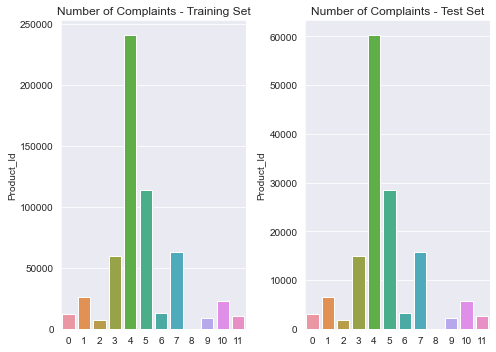

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 5))
sns.barplot(x=sorted(y_train.unique()), y=y_train.groupby(y_train).count(), ax=ax1).set_title('Number of Complaints - Training Set')
sns.barplot(x=sorted(y_test.unique()), y=y_test.groupby(y_test).count(), ax=ax2).set_title('Number of Complaints - Test Set')
fig.tight_layout()
plt.show()

# Naive bayésien

In [70]:
#classificateur bayes
pipeline_mnb = Pipeline(steps = [('TfIdf', TfidfVectorizer()),
                              ('MultinomialNB', MultinomialNB())])



In [71]:
# Parameter values to test
param_grid = {
 'TfIdf__max_features' : [5000, 6000, 7000],
# 'TfIdf__min_df': [10, 20, 30],
 'TfIdf__ngram_range' : [(1,1)],
 'TfIdf__use_idf' : [True],
 'MultinomialNB__alpha' : [0.01, 0.02, 0.05, 0.10]
}

In [72]:
grid_search_mnb = GridSearchCV(pipeline_mnb, param_grid, cv=5, verbose=1, n_jobs=6)

In [73]:
grid_search_mnb.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
Exception in thread Thread-11:
Traceback (most recent call last):
  File "C:\Users\SADDEDINE_H\Anaconda3\lib\site-packages\psutil\_pswindows.py", line 679, in wrapper
    return fun(self, *args, **kwargs)
  File "C:\Users\SADDEDINE_H\Anaconda3\lib\site-packages\psutil\_pswindows.py", line 863, in kill
    return cext.proc_kill(self.pid)
PermissionError: [WinError 5] Accès refusé

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\SADDEDINE_H\Anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\Users\SADDEDINE_H\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 567, in run
    self.flag_executor_shutting_down()
  File "C:\Users\SADDEDINE_H\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 756, in flag_executor_shutting_down
    self.kill_workers()
  File "C:\U

PicklingError: Could not pickle the task to send it to the workers.

In [27]:
grid_search_mnb.best_params_

{'MultinomialNB__alpha': 0.01,
 'TfIdf__max_features': 7000,
 'TfIdf__ngram_range': (1, 1),
 'TfIdf__use_idf': True}

In [28]:
grid_search_mnb.best_estimator_

Pipeline(steps=[('TfIdf', TfidfVectorizer(max_features=7000)),
                ('MultinomialNB', MultinomialNB(alpha=0.01))])

In [29]:
grid_search_mnb.score(X_test, y_test)

0.7849844452125821

In [30]:
predicted = grid_search_mnb.predict(X)
df1['Predicted_Category_MNB'] = predicted

In [31]:
y_predicted = grid_search_mnb.predict(X_test)

In [87]:
def plotConfusionMatrixHeatmap(input_df: pd.core.frame.DataFrame, model_name: str, figsize=(20, 18)):
   
    # Heatmap du results
    plt.figure(figsize=figsize)
    sns.heatmap(input_df, annot=True, fmt='d', cmap='Reds')
    plt.ylabel('True', fontweight='bold')
    plt.xlabel('Predicted', fontweight='bold')
    plt.title(f'Confusion Matrix - {model_name}', size=14, fontweight='bold')
    plt.show()

In [88]:
key_to_product_names = [x[1] for x in sorted(product_map.items())]

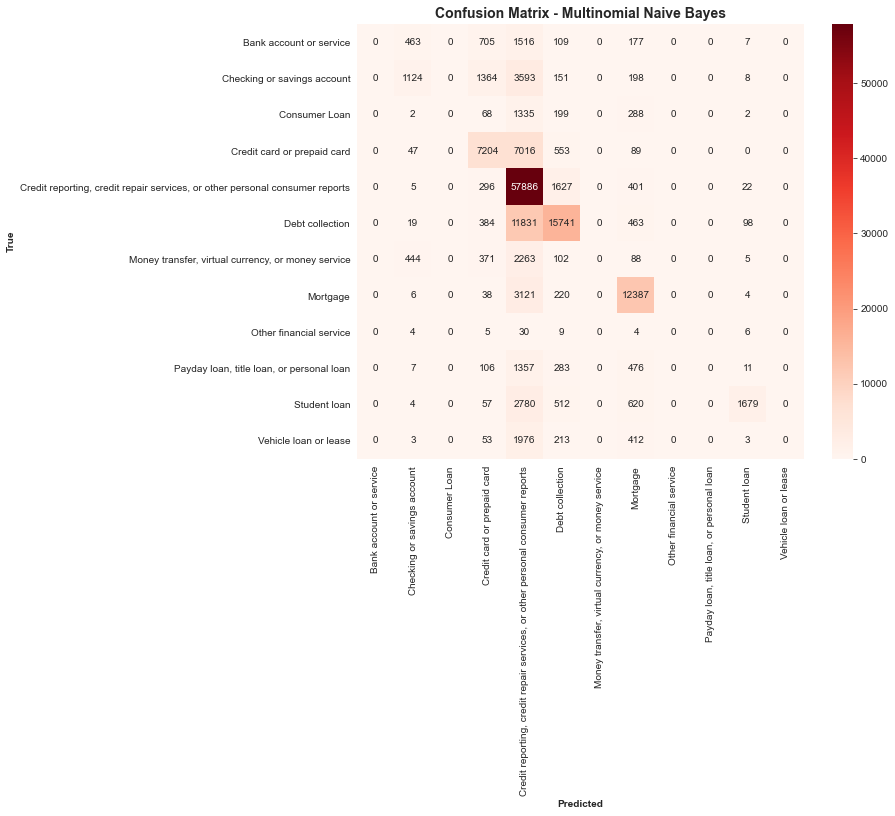

In [89]:
conf_matrix_df = pd.DataFrame(data=confusion_matrix(y_test, y_predicted),
                              index=key_to_product_names, columns=key_to_product_names)

plotConfusionMatrixHeatmap(conf_matrix_df, model_name='Multinomial Naive Bayes', figsize=(10, 8))

In [35]:
classification_report_mnb = classification_report(y_test, y_predicted, target_names=key_to_product_names)
print(classification_report_mnb)

                                                    precision    recall  f1-score   support

                           Bank account or service       0.75      0.13      0.21      2977
                       Checking or savings account       0.60      0.67      0.63      6438
                                     Consumer Loan       0.50      0.05      0.09      1894
                       Credit card or prepaid card       0.68      0.77      0.72     14909
                Credit reporting, repair, or other       0.82      0.90      0.86     60237
                                   Debt collection       0.80      0.72      0.76     28536
Money transfer, virtual currency, or money service       0.78      0.60      0.68      2974
                                   Money transfers       0.71      0.03      0.06       299
                                          Mortgage       0.84      0.92      0.88     15776
                           Other financial service       0.00      0.00      0.

# SVM

In [74]:
pipeline_lsvm = Pipeline(steps= [('TfIdf', TfidfVectorizer()),
                                 ('SGDC', SGDClassifier(verbose=1, random_state=42))])

In [75]:
# Parameter values to test
param_grid = {
 'TfIdf__max_features' : [None, 200, 300, 400],
# 'TfIdf__min_df': [10, 20, 30],
 'TfIdf__ngram_range' : [(1,1)],
 'TfIdf__use_idf' : [True],
 'SGDC__loss' : ['hinge'],
 'SGDC__alpha' : [0.001, 0.01, 0.05, 0.1]
}

In [76]:
grid_search_svc = GridSearchCV(pipeline_lsvm, param_grid, cv=10, verbose=1, n_jobs=6)

In [77]:
grid_search_svc.fit(X_train, y_train)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
Exception in thread Thread-12:
Traceback (most recent call last):
  File "C:\Users\SADDEDINE_H\Anaconda3\lib\site-packages\psutil\_pswindows.py", line 679, in wrapper
    return fun(self, *args, **kwargs)
  File "C:\Users\SADDEDINE_H\Anaconda3\lib\site-packages\psutil\_pswindows.py", line 863, in kill
    return cext.proc_kill(self.pid)
PermissionError: [WinError 5] Accès refusé

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\SADDEDINE_H\Anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\Users\SADDEDINE_H\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 567, in run
    self.flag_executor_shutting_down()
  File "C:\Users\SADDEDINE_H\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 756, in flag_executor_shutting_down
    self.kill_workers()
  File "C:\U

PicklingError: Could not pickle the task to send it to the workers.

In [42]:
grid_search_svc.best_params_

{'SGDC__alpha': 0.001,
 'SGDC__loss': 'hinge',
 'TfIdf__max_features': None,
 'TfIdf__ngram_range': (1, 1),
 'TfIdf__use_idf': True}

In [43]:
grid_search_svc.score(X_test, y_test)

0.7605945385413067

In [44]:
predicted = grid_search_svc.predict(X)
df1['Predicted_Category_LSVM'] = predicted

In [45]:
y_predicted = grid_search_svc.predict(X_test)

In [46]:
conf_matrix_df = pd.DataFrame(data=confusion_matrix(y_test, y_predicted),index=key_to_product_names,
                              columns=key_to_product_names)

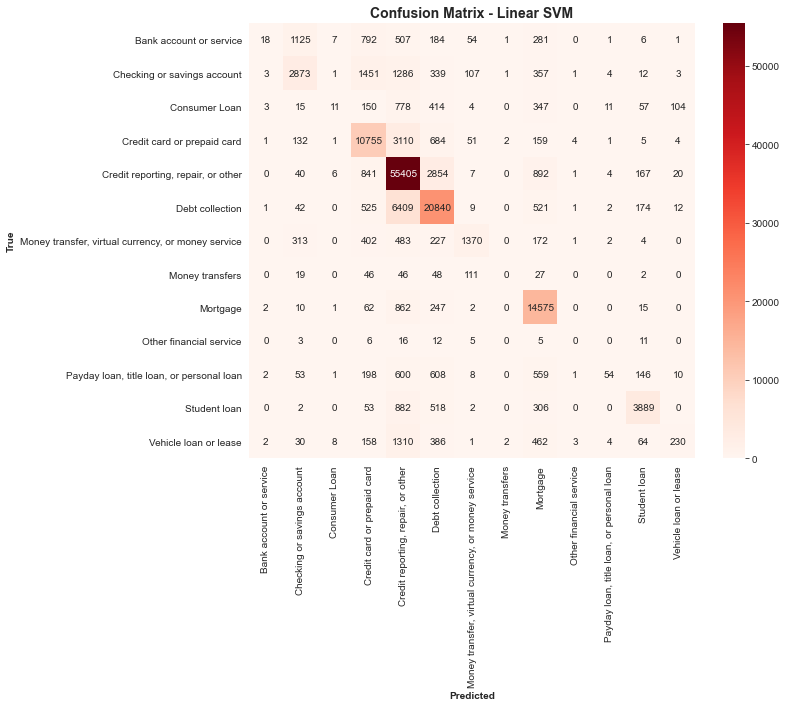

In [47]:
plotConfusionMatrixHeatmap(conf_matrix_df, model_name='Linear SVM', figsize=(10, 8))

In [48]:
classification_rep = classification_report(y_test, y_predicted,target_names=key_to_product_names)
print(classification_rep)

                                                    precision    recall  f1-score   support

                           Bank account or service       0.56      0.01      0.01      2977
                       Checking or savings account       0.62      0.45      0.52      6438
                                     Consumer Loan       0.31      0.01      0.01      1894
                       Credit card or prepaid card       0.70      0.72      0.71     14909
                Credit reporting, repair, or other       0.77      0.92      0.84     60237
                                   Debt collection       0.76      0.73      0.75     28536
Money transfer, virtual currency, or money service       0.79      0.46      0.58      2974
                                   Money transfers       0.00      0.00      0.00       299
                                          Mortgage       0.78      0.92      0.85     15776
                           Other financial service       0.00      0.00      0.

# RandomForest 

In [73]:
#clfr = DecisionTreeClassifier()
from sklearn.ensemble import RandomForestClassifier
pipeline_rfst= Pipeline(steps= [('TfIdf', TfidfVectorizer()),
                                 ('RandomForest', RandomForestClassifier( random_state=42))])

sorted(pipeline_rfst.get_params().keys())

['RandomForest',
 'RandomForest__bootstrap',
 'RandomForest__ccp_alpha',
 'RandomForest__class_weight',
 'RandomForest__criterion',
 'RandomForest__max_depth',
 'RandomForest__max_features',
 'RandomForest__max_leaf_nodes',
 'RandomForest__max_samples',
 'RandomForest__min_impurity_decrease',
 'RandomForest__min_impurity_split',
 'RandomForest__min_samples_leaf',
 'RandomForest__min_samples_split',
 'RandomForest__min_weight_fraction_leaf',
 'RandomForest__n_estimators',
 'RandomForest__n_jobs',
 'RandomForest__oob_score',
 'RandomForest__random_state',
 'RandomForest__verbose',
 'RandomForest__warm_start',
 'TfIdf',
 'TfIdf__analyzer',
 'TfIdf__binary',
 'TfIdf__decode_error',
 'TfIdf__dtype',
 'TfIdf__encoding',
 'TfIdf__input',
 'TfIdf__lowercase',
 'TfIdf__max_df',
 'TfIdf__max_features',
 'TfIdf__min_df',
 'TfIdf__ngram_range',
 'TfIdf__norm',
 'TfIdf__preprocessor',
 'TfIdf__smooth_idf',
 'TfIdf__stop_words',
 'TfIdf__strip_accents',
 'TfIdf__sublinear_tf',
 'TfIdf__token_pattern

In [74]:
# Parameter values to test
param_grid = {
 'TfIdf__max_features' : [None, 200, 300, 400],
# 'TfIdf__min_df': [10, 20, 30],
 'TfIdf__ngram_range' : [(1,1)],
 'TfIdf__use_idf' : [True],
 'RandomForest__n_estimators': [200, 500],
 'RandomForest__max_depth' : [4,5,6,7,8],
 'RandomForest__criterion' :['gini', 'entropy']
}



In [75]:
grid_search_rdf = GridSearchCV(pipeline_rfst, param_grid,verbose=1, n_jobs=6)


In [76]:
grid_search_rdf.fit(X_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed: 46.7min
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed: 367.1min
[Parallel(n_jobs=6)]: Done 400 out of 400 | elapsed: 874.0min finished


GridSearchCV(estimator=Pipeline(steps=[('TfIdf', TfidfVectorizer()),
                                       ('RandomForest',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=6,
             param_grid={'RandomForest__criterion': ['gini', 'entropy'],
                         'RandomForest__max_depth': [4, 5, 6, 7, 8],
                         'RandomForest__n_estimators': [200, 500],
                         'TfIdf__max_features': [None, 200, 300, 400],
                         'TfIdf__ngram_range': [(1, 1)],
                         'TfIdf__use_idf': [True]},
             verbose=1)

In [77]:
grid_search_rdf.best_params_

{'RandomForest__criterion': 'gini',
 'RandomForest__max_depth': 8,
 'RandomForest__n_estimators': 200,
 'TfIdf__max_features': 300,
 'TfIdf__ngram_range': (1, 1),
 'TfIdf__use_idf': True}

In [78]:
grid_search_rdf.score(X_test, y_test)

0.6638161078465261

In [82]:
predicted = grid_search_rdf.predict(X)
df1['Predicted_Category_RDF'] = predicted

In [83]:
y_predicted = grid_search_rdf.predict(X_test)

In [90]:
conf_matrix_df = pd.DataFrame(data=confusion_matrix(y_test, y_predicted),index=key_to_product_names,
                              columns=key_to_product_names)

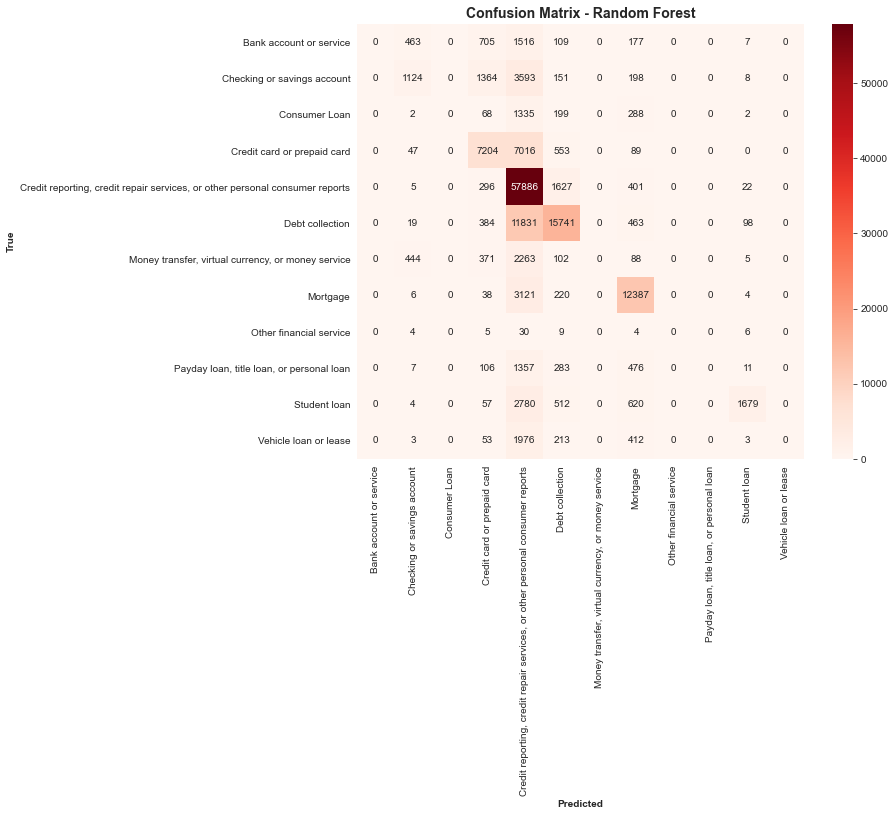

In [91]:
plotConfusionMatrixHeatmap(conf_matrix_df, model_name='Random Forest', figsize=(10, 8))

In [92]:
classification_rdf = classification_report(y_test, y_predicted,target_names=key_to_product_names)
print(classification_rdf)

                                                                              precision    recall  f1-score   support

                                                     Bank account or service       0.00      0.00      0.00      2977
                                                 Checking or savings account       0.53      0.17      0.26      6438
                                                               Consumer Loan       0.00      0.00      0.00      1894
                                                 Credit card or prepaid card       0.68      0.48      0.56     14909
Credit reporting, credit repair services, or other personal consumer reports       0.61      0.96      0.75     60237
                                                             Debt collection       0.80      0.55      0.65     28536
                          Money transfer, virtual currency, or money service       0.00      0.00      0.00      3273
                                                       

# Logistic Regression 

In [93]:
from sklearn.linear_model import LogisticRegression
pipeline_lr = Pipeline(steps= [('TfIdf', TfidfVectorizer()),
                                 ('LR', LogisticRegression(penalty='l2', random_state=777, max_iter=10000, tol=10))])

sorted(pipeline_lr.get_params().keys())

['LR',
 'LR__C',
 'LR__class_weight',
 'LR__dual',
 'LR__fit_intercept',
 'LR__intercept_scaling',
 'LR__l1_ratio',
 'LR__max_iter',
 'LR__multi_class',
 'LR__n_jobs',
 'LR__penalty',
 'LR__random_state',
 'LR__solver',
 'LR__tol',
 'LR__verbose',
 'LR__warm_start',
 'TfIdf',
 'TfIdf__analyzer',
 'TfIdf__binary',
 'TfIdf__decode_error',
 'TfIdf__dtype',
 'TfIdf__encoding',
 'TfIdf__input',
 'TfIdf__lowercase',
 'TfIdf__max_df',
 'TfIdf__max_features',
 'TfIdf__min_df',
 'TfIdf__ngram_range',
 'TfIdf__norm',
 'TfIdf__preprocessor',
 'TfIdf__smooth_idf',
 'TfIdf__stop_words',
 'TfIdf__strip_accents',
 'TfIdf__sublinear_tf',
 'TfIdf__token_pattern',
 'TfIdf__tokenizer',
 'TfIdf__use_idf',
 'TfIdf__vocabulary',
 'memory',
 'steps',
 'verbose']

In [97]:
param_grid = { 
    'TfIdf__max_features' : [None, 200, 300, 400],
# 'TfIdf__min_df': [10, 20, 30],
    'TfIdf__ngram_range' : [(1,1)],
    'TfIdf__use_idf' : [True],
    'LR__penalty' : ['l1', 'l2'],
    'LR__C': [0.001, 0.01, 0.1],
}

In [98]:
grid_search_lr = GridSearchCV(pipeline_lr, param_grid, cv=5, verbose=1, n_jobs=6)


In [99]:
grid_search_lr.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  9.7min
[Parallel(n_jobs=6)]: Done 120 out of 120 | elapsed: 40.6min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('TfIdf', TfidfVectorizer()),
                                       ('LR',
                                        LogisticRegression(max_iter=10000,
                                                           random_state=777,
                                                           tol=10))]),
             n_jobs=6,
             param_grid={'LR__C': [0.001, 0.01, 0.1],
                         'LR__penalty': ['l1', 'l2'],
                         'TfIdf__max_features': [None, 200, 300, 400],
                         'TfIdf__ngram_range': [(1, 1)],
                         'TfIdf__use_idf': [True]},
             verbose=1)

In [100]:
grid_search_lr.best_params_

{'LR__C': 0.1,
 'LR__penalty': 'l2',
 'TfIdf__max_features': None,
 'TfIdf__ngram_range': (1, 1),
 'TfIdf__use_idf': True}

In [101]:
grid_search_lr.score(X_test, y_test)

0.8167438645005185

In [102]:
predicted = grid_search_lr.predict(X)
df1['Predicted_Category_LR'] = predicted

In [103]:
y_predicted = grid_search_lr.predict(X_test)

In [104]:
conf_matrix_df = pd.DataFrame(data=confusion_matrix(y_test, y_predicted),index=key_to_product_names,
                              columns=key_to_product_names)

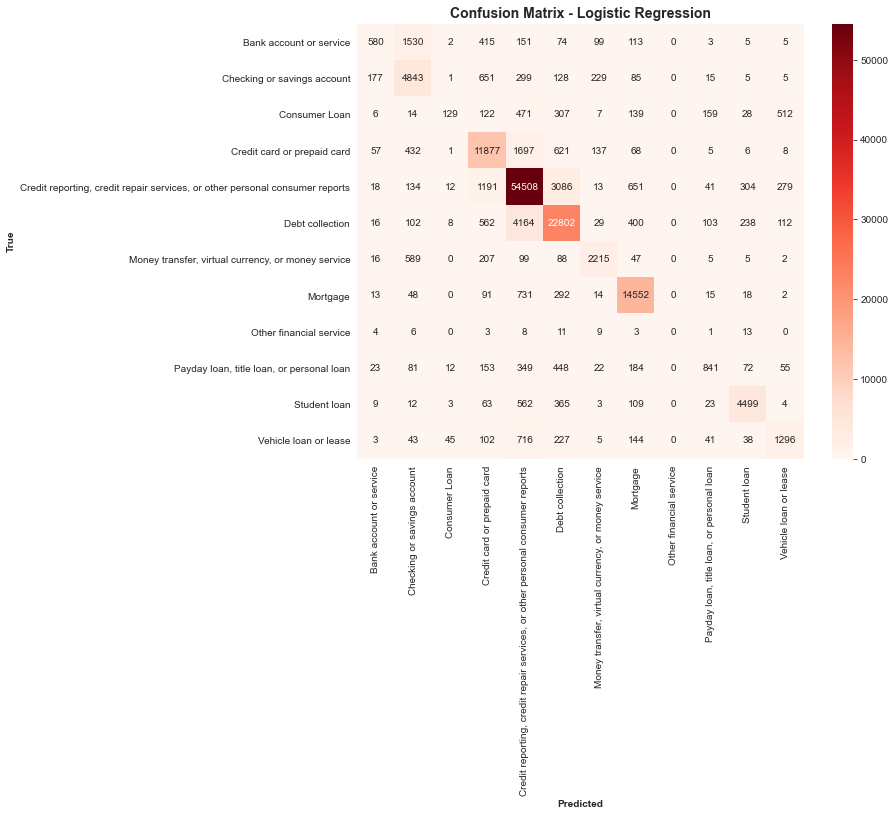

In [105]:
plotConfusionMatrixHeatmap(conf_matrix_df, model_name='Logistic Regression', figsize=(10, 8))

In [106]:
classification_lr = classification_report(y_test, y_predicted,target_names=key_to_product_names)
print(classification_lr)

                                                                              precision    recall  f1-score   support

                                                     Bank account or service       0.63      0.19      0.30      2977
                                                 Checking or savings account       0.62      0.75      0.68      6438
                                                               Consumer Loan       0.61      0.07      0.12      1894
                                                 Credit card or prepaid card       0.77      0.80      0.78     14909
Credit reporting, credit repair services, or other personal consumer reports       0.85      0.90      0.88     60237
                                                             Debt collection       0.80      0.80      0.80     28536
                          Money transfer, virtual currency, or money service       0.80      0.68      0.73      3273
                                                       

In [116]:
new_complaint = """I have been enrolled back at XXXX XXXX University in the XX/XX/XXXX. Recently, i have been harassed by \
Navient for the last month. I have faxed in paperwork providing them with everything they needed. And yet I am still getting \
phone calls for payments. Furthermore, Navient is now reporting to the credit bureaus that I am late. At this point, \
Navient needs to get their act together to avoid me taking further action. I have been enrolled the entire time and my \
deferment should be valid with my planned graduation date being the XX/XX/XXXX."""
print(models.predict(TfidfVectorizer.transform([new_complaint])))

AttributeError: 'list' object has no attribute 'predict'

In [42]:
df1[df1['complaint'] == new_complaint]

,complaint,Product,Complaint_Tokenized,Complaint_Clean,Product_Id,Predicted_Category_MNB
1780453,I have been enrolled back at XXXX XXXX Univers...,Student loan,"[enrolled, back, university, recently, harasse...",enrolled back university recently harassed nav...,11,11


In [111]:
new_complaint_2 = """Equifax exposed my personal information without my consent, as part of their recent data breach. \
In addition, they dragged their feet in the announcement of the report, and even allowed their upper management to sell \
off stock before the announcement."""
print(model.predict(fitted_vectorizer.transform([new_complaint_2])))


NameError: name 'model' is not defined

In [52]:
df1[df1['complaint'] == new_complaint_2]

,complaint,Product,Complaint_Tokenized,Complaint_Clean,Product_Id,Predicted_Category_MNB
990254,Equifax exposed my personal information withou...,"Credit reporting, repair, or other","[equifax, exposed, personal, information, with...",equifax exposed personal information without c...,4,4
